Set up Earth Engine in colab

In [6]:
!pip install earthengine-api --quiet

In [7]:
import ee

ee.Authenticate()

True

In [8]:
ee.Initialize(project='farmiq-earthengine')

Pulling NDVI data from MODIS

In [12]:
# Define point location (Oshana region)
point = ee.Geometry.Point([15.52, -17.75])  # Longitude, Latitude

# Load MODIS NDVI dataset
ndvi_collection = ee.ImageCollection('MODIS/006/MOD13Q1') \
    .filterDate('2022-01-01', '2025-07-17') \
    .filterBounds(point) \
    .select('NDVI')

# Reduce to time series for the point
def format_ndvi(image):
    date = image.date().format("YYYY-MM-dd")
    ndvi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=point,
        scale=250
    ).get('NDVI')
    return ee.Feature(None, {
        'date': date,
        'NDVI': ndvi
    })

ndvi_features = ndvi_collection.map(format_ndvi)
ndvi_fc = ee.FeatureCollection(ndvi_features)

# Convert to a table we can export
ndvi_dict = ndvi_fc.getInfo()
ndvi_data = [{'date': f['properties']['date'], 'NDVI': f['properties']['NDVI']} for f in ndvi_dict['features']]

# Convert to Pandas DataFrame
import pandas as pd
ndvi_df = pd.DataFrame(ndvi_data)
ndvi_df['NDVI'] = ndvi_df['NDVI'].astype(float) / 10000  # MODIS NDVI is scaled by 10,000

# Preview
ndvi_df.head()
print(ndvi_df.shape)

(26, 2)


Visualize NDVI time series

/tmp/ipython-input-13-447645526.py:13: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


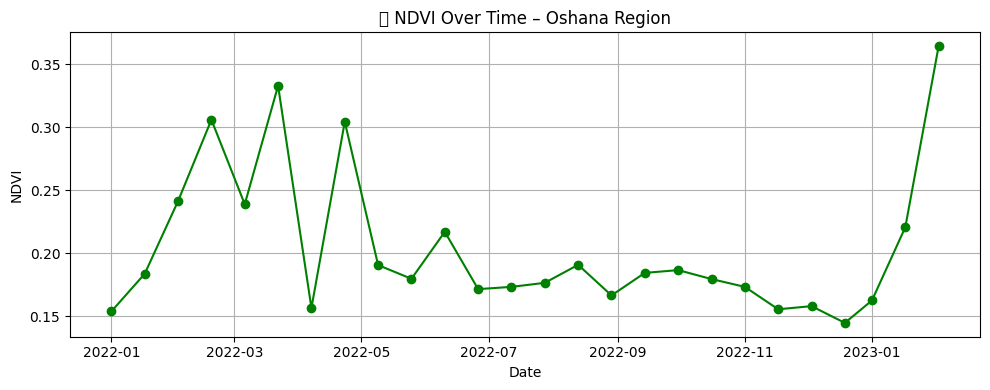

In [13]:
import matplotlib.pyplot as plt

# Convert 'date' to datetime
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ndvi_df['date'], ndvi_df['NDVI'], marker='o', color='green')
plt.title('🌿 NDVI Over Time – Oshana Region')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import plotly.express as px

fig = px.line(ndvi_df, x='date', y='NDVI', title=' NDVI Over Time – Oshana Region')
fig.show()

Our Regions Coordinates

In [16]:
regions = {
    "Kunene":       [13.77, -19.42],
    "Oshana":       [15.80, -18.43],
    "Kavango West": [18.86, -18.29],
    "Zambezi":      [23.60, -17.50],
    "Omaheke":      [19.50, -21.50],
    "Hardap":       [17.48, -24.60],
    "Erongo":       [14.95, -22.07]
}


In [17]:
def fetch_ndvi(region_name, lon, lat):
    point = ee.Geometry.Point([lon, lat])
    collection = ee.ImageCollection('MODIS/006/MOD13Q1') \
        .filterDate('2022-01-01', '2025-07-17') \
        .filterBounds(point) \
        .select('NDVI')

    def extract(image):
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'NDVI': image.reduceRegion(ee.Reducer.mean(), point, 250).get('NDVI'),
            'region': region_name
        })

    features = collection.map(extract)
    return ee.FeatureCollection(features)


In [19]:
# Fetch and merge NDVI for all regions
fc_list = []
for name, coords in regions.items():
    print(f"📍 Fetching NDVI for {name}...")
    fc = fetch_ndvi(name, coords[0], coords[1])
    fc_list.append(fc)

# Combine all into one big FeatureCollection
combined_fc = ee.FeatureCollection(fc_list).flatten()

# Convert to Python-friendly format
ndvi_all = combined_fc.getInfo()
ndvi_records = [
    {
        'date': f['properties']['date'],
        'NDVI': float(f['properties']['NDVI']) / 10000 if f['properties']['NDVI'] else None,
        'region': f['properties']['region']
    }
    for f in ndvi_all['features']
]

# Convert to DataFrame
ndvi_df = pd.DataFrame(ndvi_records)
ndvi_df.dropna(inplace=True)
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df.head()
print(ndvi_df.shape)

📍 Fetching NDVI for Kunene...
📍 Fetching NDVI for Oshana...
📍 Fetching NDVI for Kavango West...
📍 Fetching NDVI for Zambezi...
📍 Fetching NDVI for Omaheke...
📍 Fetching NDVI for Hardap...
📍 Fetching NDVI for Erongo...
(182, 3)


In [20]:
ndvi_df.to_csv("ndvi_regions.csv", index=False)

In [26]:
from google.colab import files
files.download("ndvi_regions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Pull rainfall and temperature data

In [22]:
from datetime import datetime, timedelta
import calendar

# Generate monthly ranges from Jan 2022 to July 2025
def generate_monthly_ranges(start, end):
    date_ranges = []
    current = start
    while current <= end:
        year = current.year
        month = current.month
        start_date = datetime(year, month, 1)
        end_day = calendar.monthrange(year, month)[1]
        end_date = datetime(year, month, end_day)
        date_ranges.append((start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), f"{year}-{month:02}"))
        current += timedelta(days=end_day)
    return date_ranges

monthly_ranges = generate_monthly_ranges(datetime(2022, 1, 1), datetime(2025, 7, 1))


In [23]:
def fetch_rainfall_temperature(region_name, lon, lat):
    point = ee.Geometry.Point([lon, lat])
    records = []

    for start_date, end_date, month_label in monthly_ranges:
        # Rainfall from CHIRPS
        rainfall_image = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
            .filterDate(start_date, end_date) \
            .filterBounds(point) \
            .select('precipitation') \
            .mean()  # avg rainfall over that month

        # Temperature from ERA5
        temp_image = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR") \
            .filterDate(start_date, end_date) \
            .filterBounds(point) \
            .select('temperature_2m_max') \
            .mean()

        # Reduce both to point
        rainfall = rainfall_image.reduceRegion(ee.Reducer.mean(), point, 5000).get('precipitation')
        temperature = temp_image.reduceRegion(ee.Reducer.mean(), point, 5000).get('temperature_2m_max')

        # Add result
        records.append({
            'month': month_label,
            'region': region_name,
            'rainfall_mm': rainfall,
            'temp_C': ee.Number(temperature).subtract(273.15)  # Convert from Kelvin
        })

    return records


In [24]:
all_weather = []
for name, coords in regions.items():
    print(f" Fetching satellite weather for {name}...")
    records = fetch_rainfall_temperature(name, coords[0], coords[1])
    all_weather.extend(records)


 Fetching satellite weather for Kunene...
 Fetching satellite weather for Oshana...
 Fetching satellite weather for Kavango West...
 Fetching satellite weather for Zambezi...
 Fetching satellite weather for Omaheke...
 Fetching satellite weather for Hardap...
 Fetching satellite weather for Erongo...


In [28]:
# Convert from EE objects to DataFrame
weather_data = []
for entry in all_weather:
    try:
        weather_data.append({
            'month': entry['month'],
            'region': entry['region'],
            'rainfall_mm': entry['rainfall_mm'].getInfo(),
            'temp_C': entry['temp_C'].getInfo()
        })
    except:
        pass  # skip missing values

weather_df = pd.DataFrame(weather_data)
weather_df.to_csv("satellite_rain_temp.csv", index=False)
print(" Saved: satellite_rain_temp.csv")
weather_df.head()
print(weather_df.shape)

 Saved: satellite_rain_temp.csv
(285, 4)


In [27]:
files.download("satellite_rain_temp.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>